# Large Language Model (LLM) from Scratch
### A Large Language Model (LLM) is a foundational generative AI model designed to understand and generate human-like text by learning patterns from large text corpora. It assumes that text sequences follow probabilistic patterns that can be modeled with transformer architectures, making it highly effective for tasks like text generation when trained on diverse data. This flexibility enables rapid prototyping for applications like advice generation. However, its computational intensity and need for large datasets can limit performance without significant resources.

### Use LLM as a baseline model for text generation, refining it based on the use case.

| Aspect | Details |
| :- | :- |
| Use For           | Text generation (e.g., generating financial advice)<br>Can be extended to question answering or summarization |
| Key Assumptions   | - Text sequences follow learnable patterns<br>- Sufficient data for training<br>- Adequate computational resources |
| Advantages        | - Generates coherent, context-aware text<br>- Highly flexible for various tasks<br>- Customizable for specific domains |
| Disadvantages     | - Computationally intensive to train<br>- Prone to overfitting without regularization<br>- Requires large datasets |
| Avoid When        | - Limited computational resources<br>- Small or noisy datasets<br>- Real-time applications without pre-training |
| Real-World Use Case | Advice generation (e.g., creating budget tips from prompts)<br>Summarisation <br>Chatbot responses for user queries |

## Problem Description
### Generate coherent text sequences using a small transformer-based LLM trained from scratch on the Gutenberg Project dataset. This is a text generation task where the model learns to predict the next token in a sequence, optimized for memory efficiency.

Using the Gutenberg Project dataset from Project Gutenberg: https://www.gutenberg.org/

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from collections import Counter
from datasets import load_dataset
import os

In [15]:
project_dir = './20_llm_large_language_model'
data_dir = os.path.join(project_dir, 'data')
model_dir = os.path.join(project_dir, 'model')
log_dir = os.path.join(project_dir, 'logs')

In [16]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        print("GPU available:", physical_devices)
    else:
        print("No GPU found, using CPU.")
        return

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [17]:
setup_gpu()

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1751556241.630780 2779908 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [18]:
# download NLTK data for tokenization
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/tarun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [19]:
# load OpenWebText dataset (using Hugging Face datasets for simplicity)
def load_openwebtext_financial(batch_size=1000):
    """
    Load OpenWebText dataset and filter for financial advice-related texts.
    Uses keyword matching to identify financial content.
    """
    dataset = load_dataset("openwebtext", split="train", streaming=True)
    financial_keywords = ["finance", "investment", "budget", "money", "savings", "stocks", "retirement", "debt", "credit", "tax"]

    def is_financial(text):
        return any(keyword in text.lower() for keyword in financial_keywords)

    financial_texts = []
    for example in dataset:
        if is_financial(example['text']):
            financial_texts.append(example['text'])
            if len(financial_texts) >= batch_size:
                yield financial_texts
                financial_texts = []
    if financial_texts:
        yield financial_texts

In [20]:
# tokenize and create vocabulary
def preprocess_text(texts, vocab_size=1000, seq_length=20, max_sequences=15000):
    """
    Tokenize and create sequences, limiting to max_sequences for memory control.
    
    Parameters:
    - texts: List of text strings
    - vocab_size: Number of unique words to keep (default 1000)
    - seq_length: Length of each sequence (default 20)
    - max_sequences: Maximum number of sequences to generate (default 2000)
    """
    all_tokens = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        all_tokens.extend(tokens)

    word_counts = Counter(all_tokens)
    most_common_words = [word for word, _ in word_counts.most_common(vocab_size - 1)]
    vocab = {word: idx + 1 for idx, word in enumerate(most_common_words)}
    vocab['<PAD>'] = 0

    token_ids = [vocab.get(token, 0) for token in all_tokens]
    sequences = [token_ids[i:i + seq_length] for i in range(0, len(token_ids) - seq_length, seq_length)]
    sequences = sequences[:max_sequences]
    sequences = [seq + [0] * (seq_length - len(seq)) for seq in sequences]
    return np.array(sequences), vocab

In [21]:
# generate sample text
def generate_text(model, vocab, seed_text, seq_length=20, length=50, temperature=0.7):
    inv_vocab = {v: k for k, v in vocab.items()}
    tokens = [vocab.get(word, 0) for word in word_tokenize(seed_text.lower())]
    tokens = tokens[:seq_length - 1] + [0] * (seq_length - 1 - len(tokens))
    for _ in range(length):
        input_seq = np.array([tokens[-(seq_length - 1):]])
        pred = model.predict(input_seq, verbose=0)
        # Apply temperature sampling
        pred = np.log(pred + 1e-10) / temperature  # Avoid log(0)
        pred = np.exp(pred) / np.sum(np.exp(pred))  # Softmax with temperature
        next_token = np.argmax(pred[0, -1])  # Still use argmax for simplicity, can use random.choice for true sampling
        tokens.append(next_token)
    return ' '.join([inv_vocab.get(t, '<PAD>') for t in tokens])


In [ ]:
# calculate perplexity
def calculate_perplexity(model, X, y):
    loss = model.evaluate(X, y, verbose=0)[0]
    return np.exp(loss)

# calculate BLEU score
def calculate_bleu(model, vocab, seed_text, reference_texts):
    generated = generate_text(model, vocab, seed_text).split()
    references = [ref.split() for ref in reference_texts]
    return sentence_bleu(references, generated)

# calculate ROUGE score
def calculate_rouge(model, vocab, seed_text, reference_texts):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
    generated = generate_text(model, vocab, seed_text)
    scores = [scorer.score(ref, generated) for ref in reference_texts]
    avg_scores = {
        'rouge1': np.mean([s['rouge1'].fmeasure for s in scores]),
        'rouge2': np.mean([s['rouge2'].fmeasure for s in scores])
    }
    return avg_scores

: 

In [ ]:
# load and preprocess data in batches
batch_size = 100000  # Adjust based on memory constraints
financial_batches = load_openwebtext_financial(batch_size=batch_size)

# load and preprocess data
texts = next(financial_batches)
sequences, vocab = preprocess_text(texts, vocab_size=1000, seq_length=20, max_sequences=10000)
seq_length = sequences.shape[1]
X_train = sequences[:, :-1]
y_train = tf.keras.utils.to_categorical(sequences[:, 1:], num_classes=len(vocab))

In [ ]:
# define a simple transformer model
def build_transformer(vocab_size, seq_length, d_model=32, num_heads=2):
    inputs = Input(shape=(seq_length,))
    x = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.85)(x)  # Increased dropout rate
    x = Dense(d_model, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.15))(x)  # Stronger L2 regularization
    x = Dropout(0.85)(x)
    outputs = Dense(vocab_size, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
# build and compile model
model = build_transformer(vocab_size=len(vocab), seq_length=X_train.shape[1])
model.compile(
    optimizer=Adam(learning_rate=1e-4, clipvalue=1.0),  # Clip gradients at 1.0
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=22, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

I0000 00:00:1751555846.771411 2779908 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=0.2, verbose=1,
                    callbacks=[early_stopping, reduce_lr])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1941737026.py, line 2)

In [ ]:
# Evaluate the model
print("\n### Model Evaluation")

# accuracy from training history
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")


### Model Evaluation
Final Validation Accuracy: 0.2802


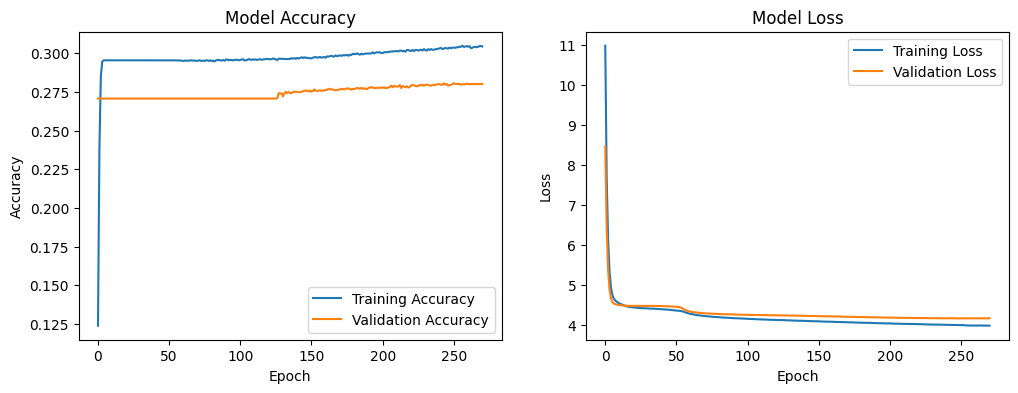

In [ ]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# benchmark tests

# Perplexity
perplexity = calculate_perplexity(model, X_train, y_train)
print(f"Perplexity: {perplexity:.2f}")

# BLEU score
reference_texts = ["save money by budgeting monthly", "invest in stocks for long-term growth"]
bleu_score = calculate_bleu(model, vocab, "Financial advice for", reference_texts)
print(f"BLEU Score: {bleu_score:.2f}")

# ROUGE score
rouge_scores = calculate_rouge(model, vocab, "Financial advice for", reference_texts)
print(f"ROUGE Scores: ROUGE-1: {rouge_scores['rouge1']:.2f}, ROUGE-2: {rouge_scores['rouge2']:.2f}")

2025-07-03 11:58:20.016101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 16 bytes spill stores, 16 bytes spill loads

2025-07-03 11:58:20.093959: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 128 bytes spill stores, 128 bytes spill loads



Perplexity: 52.05


2025-07-03 11:58:22.494415: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11', 8 bytes spill stores, 8 bytes spill loads

/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/tarun/mini

BLEU Score: 0.00
ROUGE Scores: ROUGE-1: 0.01, ROUGE-2: 0.00


In [ ]:
seed_prompts = [
    "Financial advice for investing",
    "How to save money",
    "Investing in stocks is",
    "Budgeting tips for",
    "Retirement planning involves",
    "Managing debt effectively requires",
    "Credit score improvement strategies include",
    "Emergency funds should cover",
    "Tax-saving investments can",
    "Financial independence means"
]

generated_texts = [generate_text(model, vocab, prompt) for prompt in seed_prompts]
results = pd.DataFrame({
    'Seed Prompt': seed_prompts,
    'Generated Text': generated_texts
})
print("Sample Test Results:")
print(results)

Sample Test Results:
                                   Seed Prompt  \
0               Financial advice for investing   
1                            How to save money   
2                       Investing in stocks is   
3                           Budgeting tips for   
4                 Retirement planning involves   
5           Managing debt effectively requires   
6  Credit score improvement strategies include   
7                 Emergency funds should cover   
8                   Tax-saving investments can   
9                 Financial independence means   

                                      Generated Text  
0  financial <PAD> for <PAD> <PAD> <PAD> <PAD> <P...  
1  how to <PAD> money <PAD> <PAD> <PAD> <PAD> <PA...  
2  <PAD> in <PAD> is <PAD> <PAD> <PAD> <PAD> <PAD...  
3  <PAD> <PAD> for <PAD> <PAD> <PAD> <PAD> <PAD> ...  
4  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD...  
5  <PAD> debt <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>...  
6  credit <PAD> <PAD> <PAD> include <PAD> <

In [ ]:
# save model
model.save(os.path.join(model_dir, 'llm_from_scratch.h5'))
print("Model saved successfully.")

Model saved successfully.
